Begun 1/24/25

Doing all the chi2 tests on all 264 maps after fixing ivar weighting, masking, and tfunc in bincount. Using cuts identified in data_quality_larger_set_20250124.ipynb.

Results are in angle_calc_1737661765

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1737661765/angle_calc_1737661765_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
angles_rad = np.zeros(n_maps)
errbars_rad = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = spectra_dict[maps[i]]['residual_sum']
    angles_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_angle'])
    errbars_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_errbar'])

print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits - there were none in this run
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 2000 - cuts come from analysis in data_quality_larger_set_corrected_mode_count_20241212.ipynb
residual_good = np.where(residual_sums<1900)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 4.0
ivar_good = np.where(ivar_sums>4.0)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  264
Maps passing galaxy mask cut:  249
Maps passing bad fit cut:  247
Maps passing residual cut:  165
Maps passing ivar cut:  176
Maps passing all four cuts:  138
[  1   6   7   8  20  21  22  23  24  25  26  27  28  29  30  37  38  39
  47  48  49  51  56  57  58  59  60  63  64  66  68  69  70  71  72  73
  74  75  76  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94
  96  97  98  99 100 105 113 114 115 116 117 119 120 121 122 123 128 129
 130 131 132 134 136 137 142 144 145 149 150 151 152 153 154 155 156 157
 158 159 160 162 163 173 174 175 176 177 179 180 181 182 183 185 186 187
 189 190 193 195 196 197 199 200 202 205 206 210 211 212 213 218 219 221
 222 227 228 232 233 243 244 245 247 250 251 259]


In [5]:
# Extracting map info and results into separate arrays for ease of access
map_arrays = []
map_timestamps = []
estimators = []
covariances = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)

In [6]:
good_maps = np.array(maps[set_pass_all_cuts])
print("Total number of maps passing cuts: ", len(good_maps))
print("Total number of maps: ", n_maps)
print("Number of PA4 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]))
print("Total number of PA4 maps: ", len(np.where(map_arrays=='pa4')[0]))
print("Number of PA5 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]))
print("Total number of PA5 maps: ", len(np.where(map_arrays=='pa5')[0]))
print("Number of PA6 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]))
print("Total number of PA6 maps: ", len(np.where(map_arrays=='pa6')[0]))
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
unique_good_timestamps = np.unique(good_timestamps)
print("Number of unique timestamps that pass cuts: ", len(unique_good_timestamps))

Total number of maps passing cuts:  138
Total number of maps:  264
Number of PA4 maps passing cuts:  28
Total number of PA4 maps:  88
Number of PA5 maps passing cuts:  58
Total number of PA5 maps:  92
Number of PA6 maps passing cuts:  52
Total number of PA6 maps:  84
Number of unique timestamps that pass cuts:  62


In [7]:
# Generating a list of all pairs of indices that need to be processed
# Also makes a list of strings showing which arrays each pair goes with for easy counting
all_pairs = []
all_pairs_array_tags = []
for timestamp in unique_good_timestamps:
    indices = set_pass_all_cuts[np.where(good_timestamps==timestamp)[0]] # Getting indices from full list
    if len(indices)>1:
        pairs = [comb for comb in combinations(indices,r=2)]
        for pair in pairs:
            all_pairs.append(pair)
            all_pairs_array_tags.append(map_arrays[pair[0]]+map_arrays[pair[1]])
all_pairs = np.array(all_pairs)
all_pairs_array_tags = np.array(all_pairs_array_tags)
# Getting indices within all_pairs for each set of arrays
pa4pa5_indices = np.where(all_pairs_array_tags=='pa4pa5')[0]
pa4pa6_indices = np.where(all_pairs_array_tags=='pa4pa6')[0]
pa5pa6_indices = np.where(all_pairs_array_tags=='pa5pa6')[0]
print("Total number of array difference pairs: ", len(all_pairs))
print("Total number of array tags: ", len(all_pairs_array_tags))
print("Number of pa4-pa5 pairs: ", pa4pa5_indices.size)
print("Number of pa4-pa6 pairs: ", pa4pa6_indices.size)
print("Number of pa5-pa6 pairs: ", pa5pa6_indices.size)

Total number of array difference pairs:  103
Total number of array tags:  103
Number of pa4-pa5 pairs:  28
Number of pa4-pa6 pairs:  27
Number of pa5-pa6 pairs:  48


In [30]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
chi2_all_pairs = []
pte_all_pairs = []
est_diff_all_pairs = []
cov_sum_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]] - estimators[pair[1]]
    cov_sum = covariances[pair[0]] + covariances[pair[1]]
    chi2_pair = np.sum(est_diff**2/(1.0*cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs.append(est_diff)
    cov_sum_all_pairs.append(cov_sum)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
est_diff_all_pairs = np.array(est_diff_all_pairs)
cov_sum_all_pairs = np.array(cov_sum_all_pairs)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

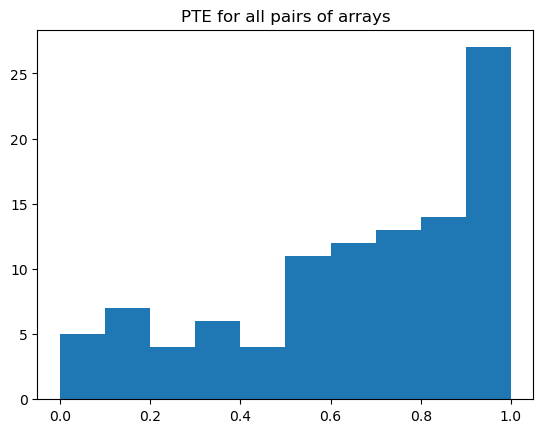

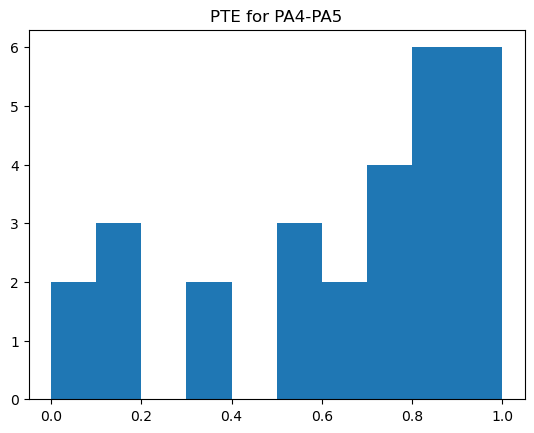

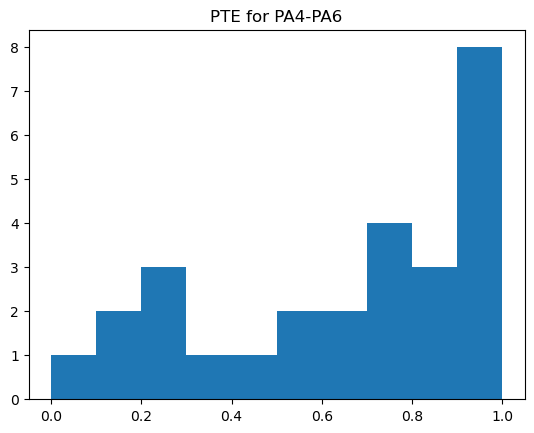

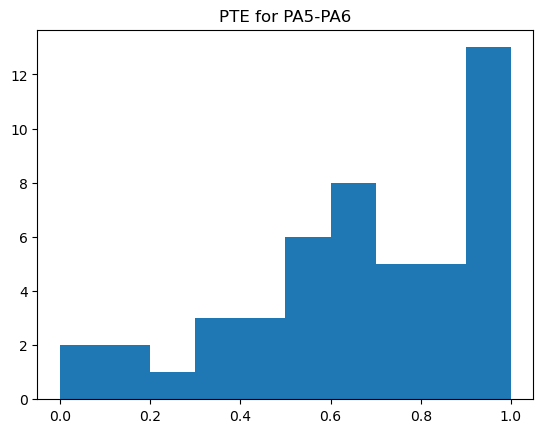

In [31]:
# Making PTE distribution plots 
# All pairs
plt.hist(pte_all_pairs,bins=10,range=(0.0,1.0))
plt.title("PTE for all pairs of arrays")
plt.show()
plt.close()
# PA4-PA5
plt.hist(pte_all_pairs[pa4pa5_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA5")
plt.show()
plt.close()
# PA4-PA6
plt.hist(pte_all_pairs[pa4pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA6")
plt.show()
plt.close()
# PA5-PA6
plt.hist(pte_all_pairs[pa5pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA5-PA6")
plt.show()
plt.close()

In [63]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
# neglecting n number of lower bins
n = 1
chi2_all_pairs = []
pte_all_pairs = []
est_diff_all_pairs = []
cov_sum_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]][n:] - estimators[pair[1]][n:]
    cov_sum = covariances[pair[0]][n:] + covariances[pair[1]][n:]
    chi2_pair = np.sum(est_diff**2/(1.0*cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs.append(est_diff)
    cov_sum_all_pairs.append(cov_sum)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
est_diff_all_pairs = np.array(est_diff_all_pairs)
cov_sum_all_pairs = np.array(cov_sum_all_pairs)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

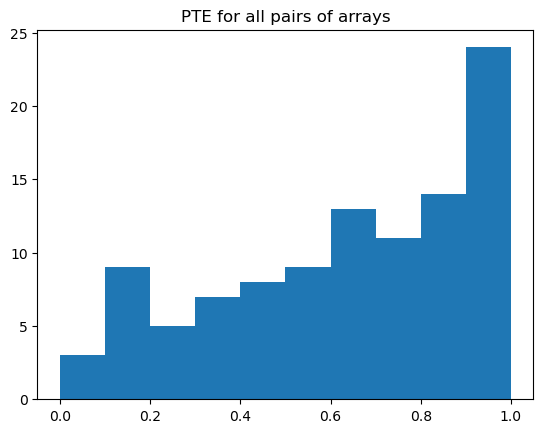

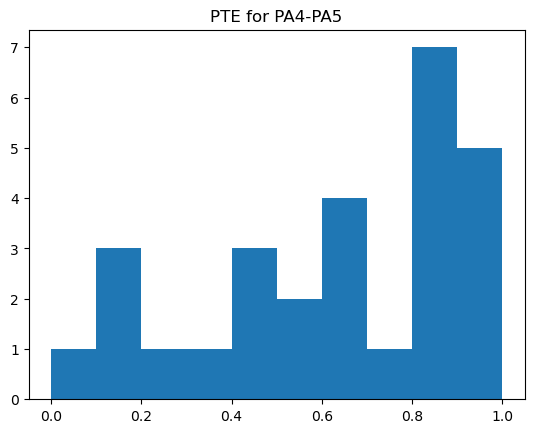

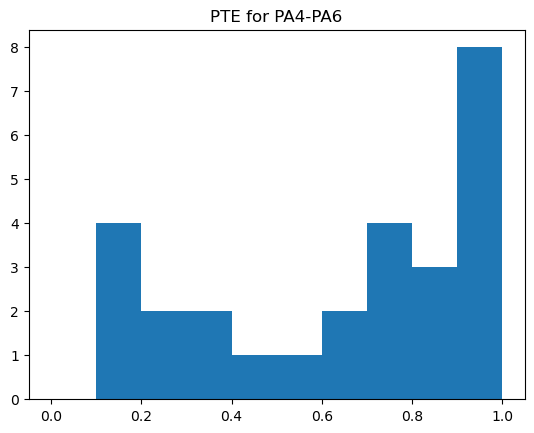

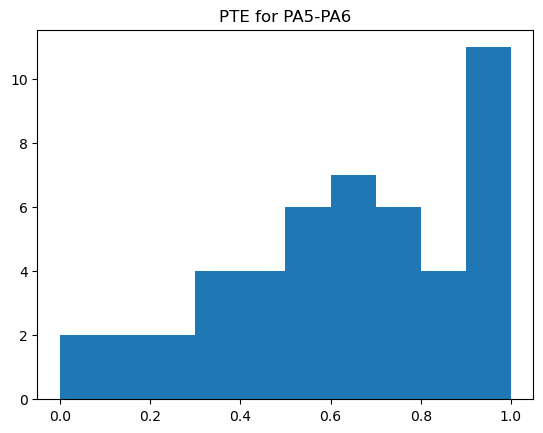

In [64]:
# Making PTE distribution plots - neglecting n number of lower bins
# All pairs
plt.hist(pte_all_pairs,bins=10,range=(0.0,1.0))
plt.title("PTE for all pairs of arrays")
plt.show()
plt.close()
# PA4-PA5
plt.hist(pte_all_pairs[pa4pa5_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA5")
plt.show()
plt.close()
# PA4-PA6
plt.hist(pte_all_pairs[pa4pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA6")
plt.show()
plt.close()
# PA5-PA6
plt.hist(pte_all_pairs[pa5pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA5-PA6")
plt.show()
plt.close()

In [35]:
# Calculating chi2 for each map compared to theory for the best fit angle
# for all maps that pass cuts
chi2_good_maps = []
pte_good_maps = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']

for idx in set_pass_all_cuts:
    null = estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    sum_cov = covariances[idx] + (test_CAMB_EE*np.sin(2*errbars_rad[idx]))**2 # correct in small angle approx, I think
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)

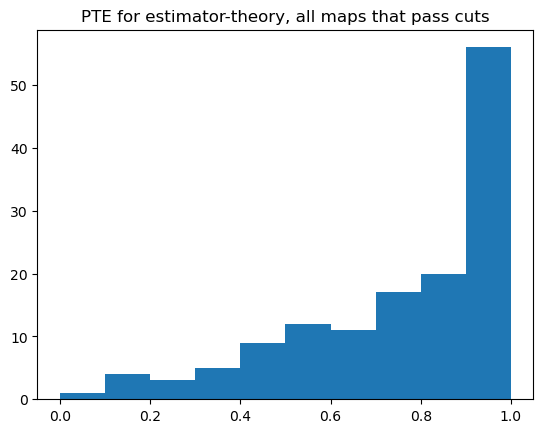

In [33]:
plt.hist(pte_good_maps,bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, all maps that pass cuts")
plt.show()
plt.close()

In [120]:
# Doing full error propagation calculation to get covariance in terms of 
# the theoretical covariance of the CAMB spectrum, the best fit angle,
# and the best fit errorbar
chi2_good_maps = []
pte_good_maps = []
all_theory_covs = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
ell = spectra_dict[maps[0]]['ell']
bin_size = 200
nu_b = (2*ell+1)*bin_size

for idx in set_pass_all_cuts:
    null = estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    theory_cov = 2*test_CAMB_EE**2 * ((np.sin(2*angles_rad[idx])**2/nu_b)+2*np.cos(2*angles_rad[idx])**2*errbars_rad[idx]**2)
    sum_cov = covariances[idx] + theory_cov
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
    all_theory_covs.append(theory_cov)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)
all_theory_covs = np.array(all_theory_covs)

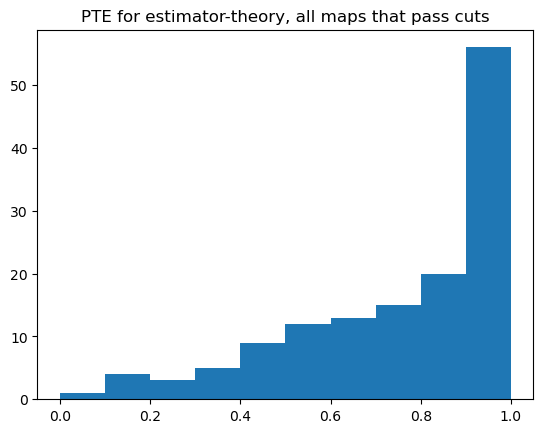

In [121]:
plt.hist(pte_good_maps,bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, all maps that pass cuts")
plt.show()
plt.close()

In [95]:
2*test_CAMB_EE**2

array([2.38629176e-07, 1.04576429e-07, 9.84389407e-08, 1.54167936e-08,
       8.30926325e-09, 3.87343492e-09, 7.10452985e-10, 3.78857342e-10,
       1.07505030e-10, 2.95495234e-11])

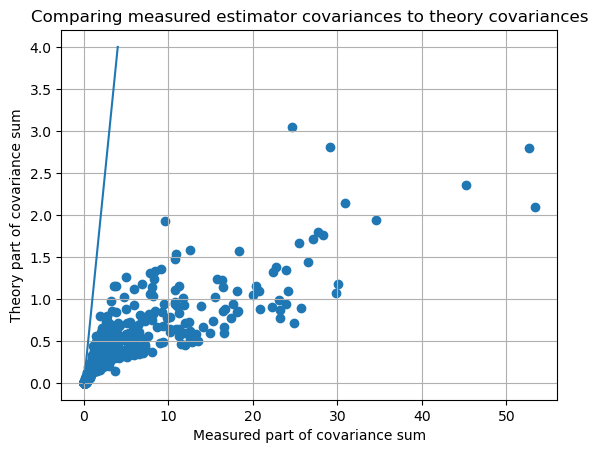

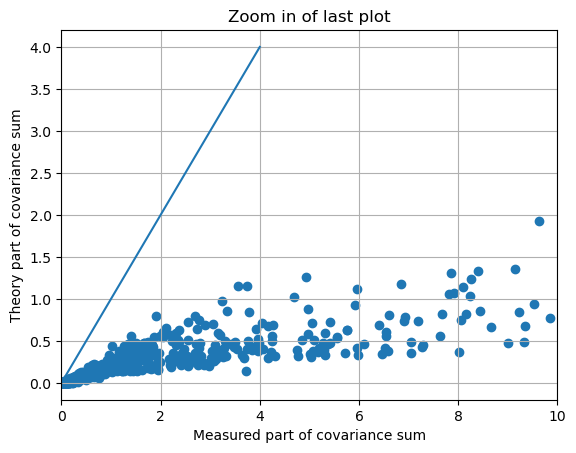

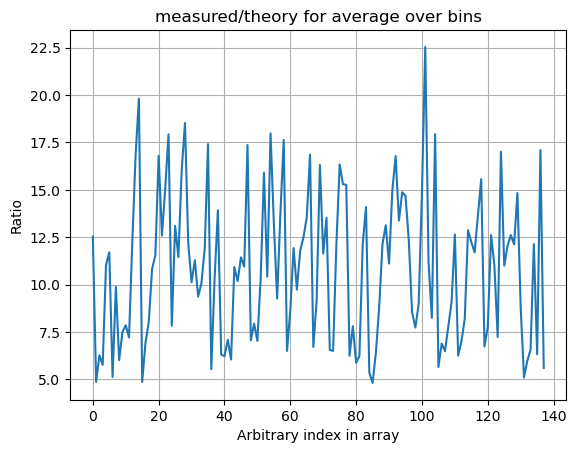

In [111]:
scale_factor = 1e-8
plt.scatter(covariances[set_pass_all_cuts]/scale_factor, all_theory_covs/scale_factor)
plt.plot(np.arange(0.0,5.0,1.0),np.arange(0.0,5.0,1.0))
plt.title("Comparing measured estimator covariances to theory covariances")
plt.xlabel("Measured part of covariance sum")
plt.ylabel("Theory part of covariance sum")
plt.grid()
plt.show()
plt.close()
scale_factor = 1e-8
plt.scatter(covariances[set_pass_all_cuts]/scale_factor, all_theory_covs/scale_factor)
plt.plot(np.arange(0.0,5.0,1.0),np.arange(0.0,5.0,1.0))
plt.title("Zoom in of last plot")
plt.xlabel("Measured part of covariance sum")
plt.ylabel("Theory part of covariance sum")
plt.xlim(0,10)
plt.grid()
plt.show()
plt.close()
plt.plot(np.mean(covariances[set_pass_all_cuts],axis=1)/np.mean(all_theory_covs,axis=1))
plt.title("measured/theory for average over bins")
plt.xlabel("Arbitrary index in array")
plt.ylabel("Ratio")
plt.grid()
plt.show()
plt.close()

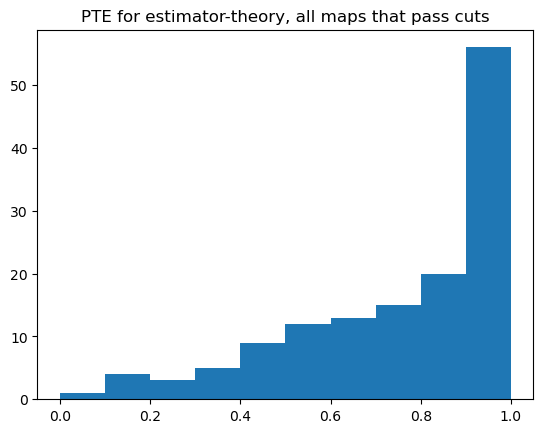

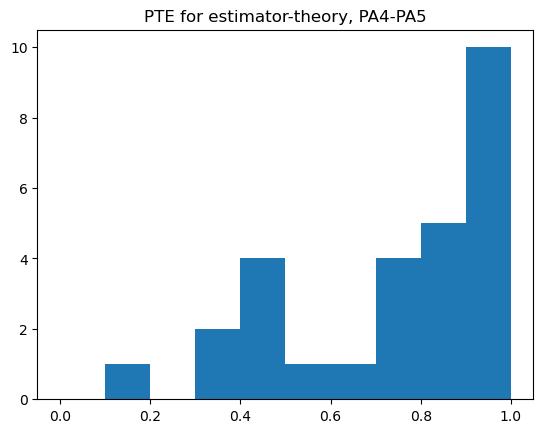

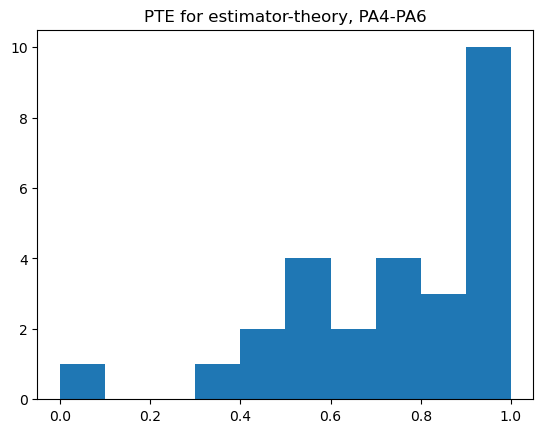

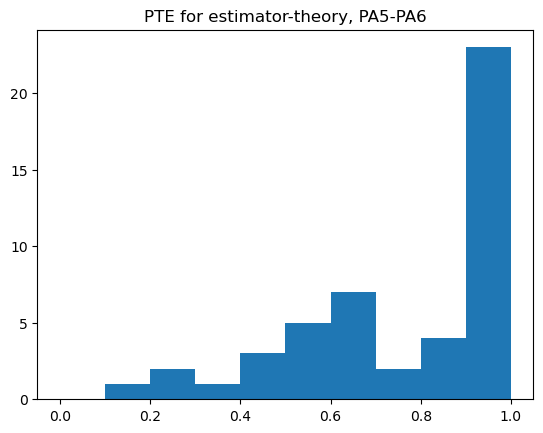

In [122]:
# Breaking out the PTE by array for this null test
plt.hist(pte_good_maps,bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, all maps that pass cuts")
plt.show()
plt.close()
# PA4-PA5
plt.hist(pte_good_maps[pa4pa5_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, PA4-PA5")
plt.show()
plt.close()
# PA4-PA6
plt.hist(pte_good_maps[pa4pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, PA4-PA6")
plt.show()
plt.close()
# PA5-PA6
plt.hist(pte_good_maps[pa5pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, PA5-PA6")
plt.show()
plt.close()